# Block 1: Environment Setup & Imports


In [1]:
# Import necessary libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import matplotlib.pyplot as plt
import os

# Check GPU availability
print("TensorFlow version:", tf.__version__)
print("GPU Available:", tf.config.list_physical_devices('GPU'))

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

2026-02-02 07:55:44.661144: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1770018944.852825      23 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1770018944.907398      23 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1770018945.386838      23 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1770018945.386881      23 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1770018945.386884      23 computation_placer.cc:177] computation placer alr

TensorFlow version: 2.19.0
GPU Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


# Block 2: Data Loading & Preprocessing


In [2]:
# Load CIFAR-10 dataset
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()

# Normalize pixel values to [0, 1]
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

# Convert labels to categorical
y_train = keras.utils.to_categorical(y_train, 10)
y_test = keras.utils.to_categorical(y_test, 10)

print(f"Training data shape: {x_train.shape}")
print(f"Training labels shape: {y_train.shape}")
print(f"Test data shape: {x_test.shape}")
print(f"Test labels shape: {y_test.shape}")

# CIFAR-10 class names
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 
               'dog', 'frog', 'horse', 'ship', 'truck']

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 8s 0us/step
Training data shape: (50000, 32, 32, 3)
Training labels shape: (50000, 10)
Test data shape: (10000, 32, 32, 3)
Test labels shape: (10000, 10)


# Block 3: Data Augmentation Setup


In [3]:
# Data augmentation for training
train_datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    zoom_range=0.1,
    fill_mode='nearest'
)

# No augmentation for validation/test
test_datagen = ImageDataGenerator()

# Create data generators
batch_size = 128
train_generator = train_datagen.flow(x_train, y_train, batch_size=batch_size)
test_generator = test_datagen.flow(x_test, y_test, batch_size=batch_size, shuffle=False)

# Block 4: Residual Block Implementation 


In [4]:
def residual_block(x, filters, kernel_size=3, stride=1, conv_shortcut=False, name=None):
    """
    A residual block for ResNet-18/34 (Basic Block)
    
    Args:
        x: input tensor
        filters: number of filters
        kernel_size: kernel size for convolution
        stride: stride for first convolution
        conv_shortcut: use convolution for shortcut (True) or identity (False)
        name: block label
    """
    bn_axis = 3  # Channel axis for 'channels_last'
    
    if conv_shortcut:
        shortcut = layers.Conv2D(filters, 1, strides=stride, name=name + '_0_conv')(x)
        shortcut = layers.BatchNormalization(axis=bn_axis, name=name + '_0_bn')(shortcut)
    else:
        shortcut = x
    
    # First convolution
    x = layers.Conv2D(filters, kernel_size, strides=stride, padding='same', 
                      use_bias=False, name=name + '_1_conv')(x)
    x = layers.BatchNormalization(axis=bn_axis, name=name + '_1_bn')(x)
    x = layers.Activation('relu', name=name + '_1_relu')(x)
    
    # Second convolution
    x = layers.Conv2D(filters, kernel_size, padding='same', 
                      use_bias=False, name=name + '_2_conv')(x)
    x = layers.BatchNormalization(axis=bn_axis, name=name + '_2_bn')(x)
    
    # Add shortcut
    x = layers.Add(name=name + '_add')([shortcut, x])
    x = layers.Activation('relu', name=name + '_out')(x)
    
    return x

# Block 5: ResNet-34 Architecture


In [5]:
def ResNet34(input_shape=(32, 32, 3), num_classes=10):
    """
    ResNet-34 architecture adapted for CIFAR-10
    
    Architecture:
    - conv1: 1 layer
    - conv2_x: 3 residual blocks (64 filters)
    - conv3_x: 4 residual blocks (128 filters)
    - conv4_x: 6 residual blocks (256 filters)
    - conv5_x: 3 residual blocks (512 filters)
    Total: 34 layers
    """
    inputs = layers.Input(shape=input_shape)
    
    # Initial convolution (adapted for CIFAR-10's smaller images)
    x = layers.Conv2D(64, 3, strides=1, padding='same', use_bias=False, name='conv1_conv')(inputs)
    x = layers.BatchNormalization(axis=3, name='conv1_bn')(x)
    x = layers.Activation('relu', name='conv1_relu')(x)
    # Note: No MaxPooling for CIFAR-10 due to small image size
    
    # Stage 1: 3 residual blocks with 64 filters
    x = residual_block(x, 64, name='conv2_block1')
    x = residual_block(x, 64, name='conv2_block2')
    x = residual_block(x, 64, name='conv2_block3')
    
    # Stage 2: 4 residual blocks with 128 filters
    x = residual_block(x, 128, stride=2, conv_shortcut=True, name='conv3_block1')
    x = residual_block(x, 128, name='conv3_block2')
    x = residual_block(x, 128, name='conv3_block3')
    x = residual_block(x, 128, name='conv3_block4')
    
    # Stage 3: 6 residual blocks with 256 filters
    x = residual_block(x, 256, stride=2, conv_shortcut=True, name='conv4_block1')
    x = residual_block(x, 256, name='conv4_block2')
    x = residual_block(x, 256, name='conv4_block3')
    x = residual_block(x, 256, name='conv4_block4')
    x = residual_block(x, 256, name='conv4_block5')
    x = residual_block(x, 256, name='conv4_block6')
    
    # Stage 4: 3 residual blocks with 512 filters
    x = residual_block(x, 512, stride=2, conv_shortcut=True, name='conv5_block1')
    x = residual_block(x, 512, name='conv5_block2')
    x = residual_block(x, 512, name='conv5_block3')
    
    # Global Average Pooling
    x = layers.GlobalAveragePooling2D(name='avg_pool')(x)
    
    # Fully connected layer
    outputs = layers.Dense(num_classes, activation='softmax', name='predictions')(x)
    
    # Create model
    model = models.Model(inputs, outputs, name='resnet34')
    
    return model

# Block 6: Model Creation & Summary


In [6]:
# Create the model
model = ResNet34(input_shape=(32, 32, 3), num_classes=10)

# Display model summary
model.summary()

# Count total parameters
total_params = model.count_params()
print(f"\nTotal parameters: {total_params:,}")

I0000 00:00:1770018970.661219      23 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15511 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


Model: "resnet34"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 32, 32, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 32, 32,    │      1,728 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 32, 32,    │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 32, 32,    │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 32, 32,    │     36,864 │ conv1_relu[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 32, 32,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 32, 32,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 32, 32,    │     36,864 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 32, 32,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_add    │ (None, 32, 32,    │          0 │ conv1_relu[0][0], │
│ (Add)               │ 64)               │            │ conv2_block1_2_b… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_out    │ (None, 32, 32,    │          0 │ conv2_block1_add… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_1_conv │ (None, 32, 32,    │     36,864 │ conv2_block1_out… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_1_bn   │ (None, 32, 32,    │        256 │ conv2_block2_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_1_relu │ (None, 32, 32,    │          0 │ conv2_block2_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_2_conv │ (None, 32, 32,    │     36,864 │ conv2_block2_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_2_bn   │ (None, 32, 32,    │        256 │ conv2_block2_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_add    │ (None, 32, 32,    │          0 │ conv2_block1_out

 Total params: 21,300,042 (81.25 MB)

 Trainable params: 21,283,018 (81.19 MB)

 Non-trainable params: 17,024 (66.50 KB)


Total parameters: 21,300,042


# Block 7: Compile Model


In [7]:
# Define optimizer
initial_learning_rate = 0.1

# Compile model
model.compile(
    optimizer=optimizers.SGD(learning_rate=initial_learning_rate, momentum=0.9, nesterov=True),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print("Model compiled successfully!")

Model compiled successfully!


# Block 8: Callbacks Setup


In [8]:
# Create directory for saving models
os.makedirs('./models', exist_ok=True)

# Model checkpoint - save best model
checkpoint = ModelCheckpoint(
    './models/resnet34_cifar10_best.keras',
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)

# Reduce learning rate when plateau
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=1e-6,
    verbose=1
)

# Early stopping
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=15,
    restore_best_weights=True,
    verbose=1
)

callbacks = [checkpoint, reduce_lr, early_stop]

# Block 9: Training


In [9]:
# Training parameters
epochs = 100
steps_per_epoch = len(x_train) // batch_size

# Train the model
history = model.fit(
    train_generator,
    epochs=epochs,
    steps_per_epoch=steps_per_epoch,
    validation_data=(x_test, y_test),
    callbacks=callbacks,
    verbose=1
)

print("\nTraining completed!")

Epoch 1/100


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1770018983.900481      64 service.cc:152] XLA service 0x7e640c0038e0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1770018983.900528      64 service.cc:160]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1770018985.555787      64 cuda_dnn.cc:529] Loaded cuDNN version 91002


  1/390 ━━━━━━━━━━━━━━━━━━━━ 2:27:34 23s/step - accuracy: 0.0703 - loss: 3.3949

I0000 00:00:1770018995.805677      64 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


390/390 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy: 0.1831 - loss: 3.2697
Epoch 1: val_accuracy improved from -inf to 0.17410, saving model to ./models/resnet34_cifar10_best.keras
390/390 ━━━━━━━━━━━━━━━━━━━━ 82s 152ms/step - accuracy: 0.1833 - loss: 3.2671 - val_accuracy: 0.1741 - val_loss: 3.3445 - learning_rate: 0.1000
Epoch 2/100
  1/390 ━━━━━━━━━━━━━━━━━━━━ 40s 104ms/step - accuracy: 0.4297 - loss: 1.7569

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 2: val_accuracy did not improve from 0.17410
390/390 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.4297 - loss: 1.7569 - val_accuracy: 0.1657 - val_loss: 3.1579 - learning_rate: 0.1000
Epoch 3/100
390/390 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - accuracy: 0.3772 - loss: 1.6830
Epoch 3: val_accuracy improved from 0.17410 to 0.39300, saving model to ./models/resnet34_cifar10_best.keras
390/390 ━━━━━━━━━━━━━━━━━━━━ 45s 114ms/step - accuracy: 0.3773 - loss: 1.6828 - val_accuracy: 0.3930 - val_loss: 1.6386 - learning_rate: 0.1000
Epoch 4/100
  1/390 ━━━━━━━━━━━━━━━━━━━━ 38s 100ms/step - accuracy: 0.4453 - loss: 1.5552
Epoch 4: val_accuracy improved from 0.39300 to 0.41960, saving model to ./models/resnet34_cifar10_best.keras
390/390 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.4453 - loss: 1.5552 - val_accuracy: 0.4196 - val_loss: 1.5592 - learning_rate: 0.1000
Epoch 5/100
390/390 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - accuracy: 0.4588 - loss: 1.4742
Epoch 5: val_accuracy improved fro

# Block 10: Training History Visualization


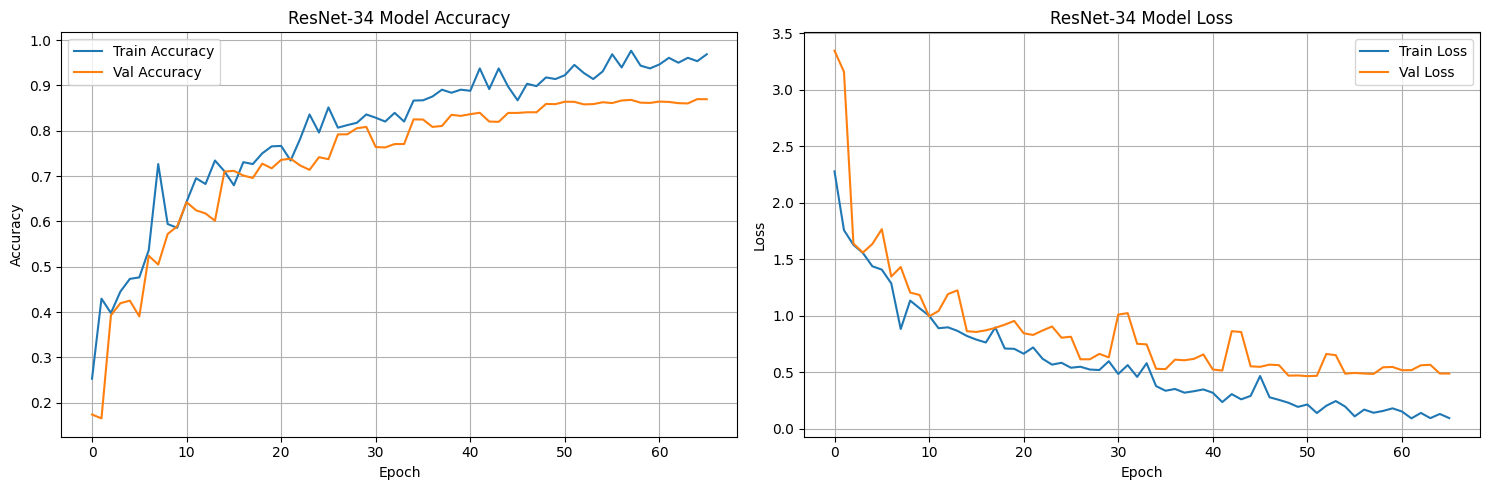

In [10]:
# Plot training history
def plot_history(history):
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    
    # Accuracy plot
    axes[0].plot(history.history['accuracy'], label='Train Accuracy')
    axes[0].plot(history.history['val_accuracy'], label='Val Accuracy')
    axes[0].set_title('ResNet-34 Model Accuracy')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Accuracy')
    axes[0].legend()
    axes[0].grid(True)
    
    # Loss plot
    axes[1].plot(history.history['loss'], label='Train Loss')
    axes[1].plot(history.history['val_loss'], label='Val Loss')
    axes[1].set_title('ResNet-34 Model Loss')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Loss')
    axes[1].legend()
    axes[1].grid(True)
    
    plt.tight_layout()
    plt.savefig('resnet34_training_history.png', dpi=300, bbox_inches='tight')
    plt.show()

plot_history(history)

# Block 11: Model Evaluation


In [11]:
# Evaluate on test set
test_loss, test_accuracy = model.evaluate(x_test, y_test, verbose=1)
print(f"\nTest Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")

# Get predictions
predictions = model.predict(x_test)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = np.argmax(y_test, axis=1)

313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - accuracy: 0.8662 - loss: 0.4583

Test Loss: 0.4658
Test Accuracy: 0.8641 (86.41%)
313/313 ━━━━━━━━━━━━━━━━━━━━ 8s 19ms/step


# Block 12: Confusion Matrix & Classification Report


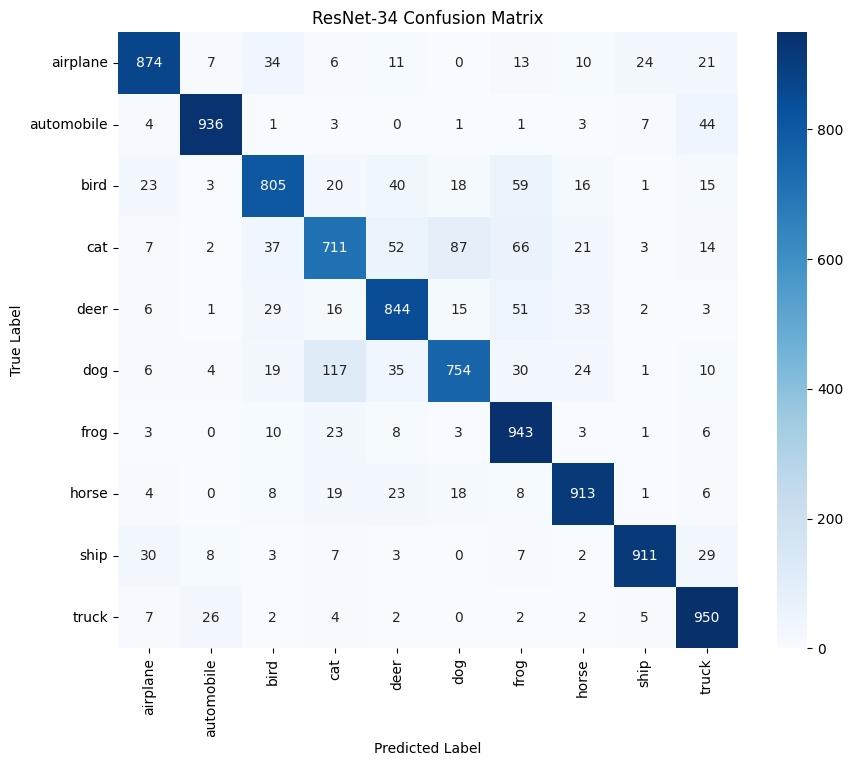


Classification Report:
              precision    recall  f1-score   support

    airplane       0.91      0.87      0.89      1000
  automobile       0.95      0.94      0.94      1000
        bird       0.85      0.81      0.83      1000
         cat       0.77      0.71      0.74      1000
        deer       0.83      0.84      0.84      1000
         dog       0.84      0.75      0.80      1000
        frog       0.80      0.94      0.87      1000
       horse       0.89      0.91      0.90      1000
        ship       0.95      0.91      0.93      1000
       truck       0.87      0.95      0.91      1000

    accuracy                           0.86     10000
   macro avg       0.86      0.86      0.86     10000
weighted avg       0.86      0.86      0.86     10000



In [12]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names)
plt.title('ResNet-34 Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.savefig('resnet34_confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

# Classification report
print("\nClassification Report:")
print(classification_report(true_classes, predicted_classes, target_names=class_names))

# Block 13: Visualize Predictions


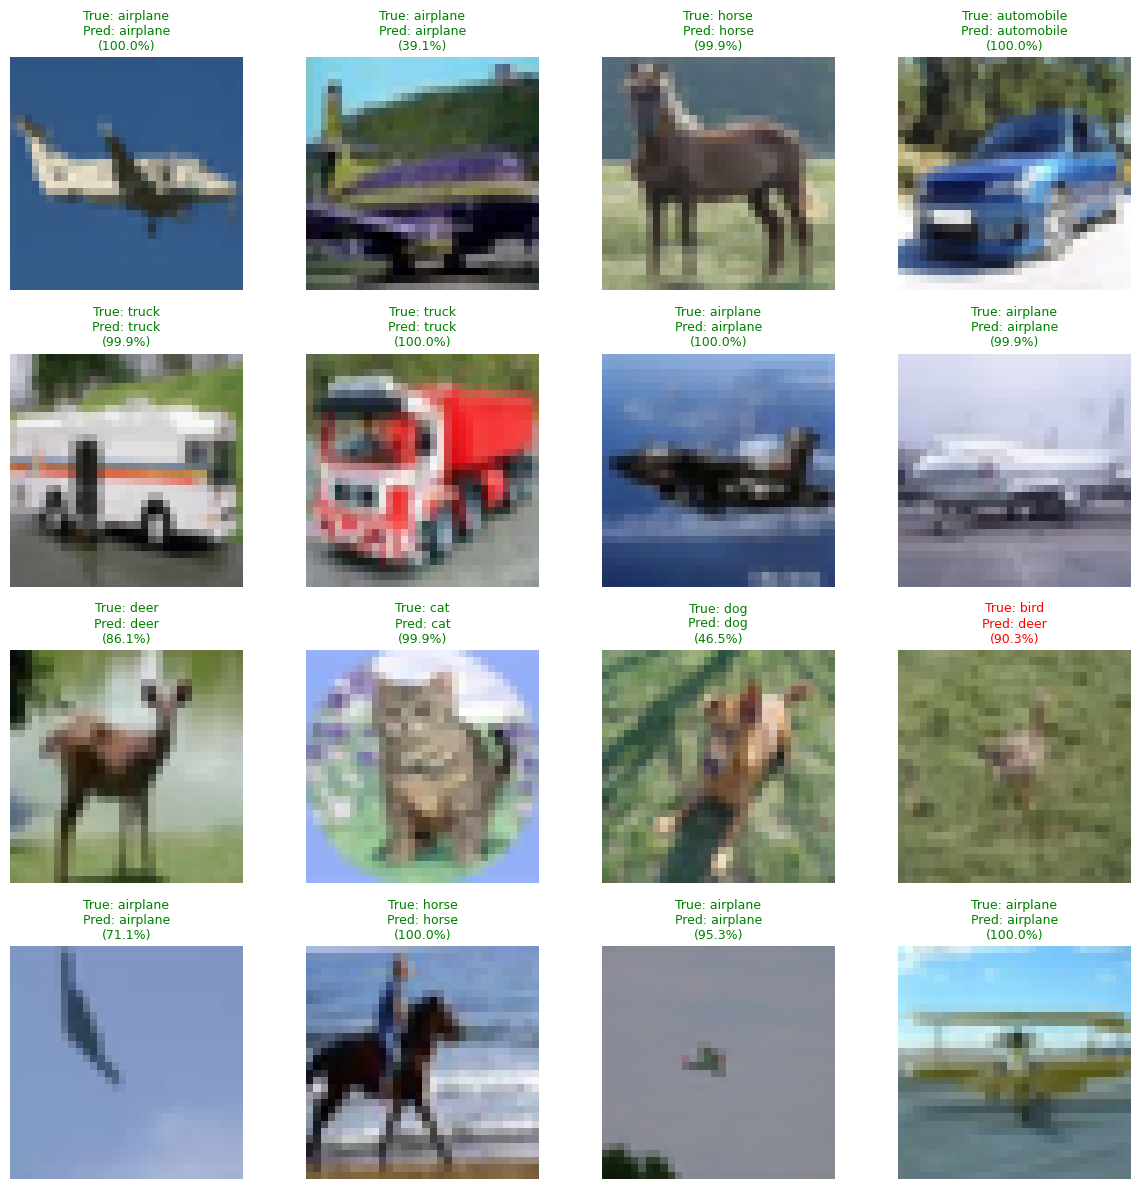

In [13]:
# Visualize some predictions
def visualize_predictions(num_images=16):
    indices = np.random.choice(len(x_test), num_images, replace=False)
    
    fig, axes = plt.subplots(4, 4, figsize=(12, 12))
    axes = axes.ravel()
    
    for i, idx in enumerate(indices):
        axes[i].imshow(x_test[idx])
        true_label = class_names[true_classes[idx]]
        pred_label = class_names[predicted_classes[idx]]
        confidence = predictions[idx][predicted_classes[idx]] * 100
        
        color = 'green' if true_label == pred_label else 'red'
        axes[i].set_title(f'True: {true_label}\nPred: {pred_label}\n({confidence:.1f}%)', 
                         color=color, fontsize=9)
        axes[i].axis('off')
    
    plt.tight_layout()
    plt.savefig('resnet34_predictions_sample.png', dpi=300, bbox_inches='tight')
    plt.show()

visualize_predictions()

# Block 14: Save Final Model


In [14]:
# Save the complete model in native Keras format
model.save('./models/resnet34_cifar10_final.keras')
print("Final model saved in Keras format!")

# Save model architecture as JSON
model_json = model.to_json()
with open('./models/resnet34_architecture.json', 'w') as json_file:
    json_file.write(model_json)
print("Model architecture saved!")

# Save weights separately
model.save_weights('./models/resnet34.weights.h5')
print("Model weights saved!")

print("\nModel files created:")
print("  - resnet34_cifar10_final.keras (complete model)")
print("  - resnet34.weights.h5 (weights only)")
print("  - resnet34_architecture.json (architecture)")

Final model saved in Keras format!
Model architecture saved!
Model weights saved!

Model files created:
  - resnet34_cifar10_final.keras (complete model)
  - resnet34.weights.h5 (weights only)
  - resnet34_architecture.json (architecture)


# Block 15: Per-Class Accuracy Analysis


In [15]:
# Calculate per-class accuracy
from collections import defaultdict

class_correct = defaultdict(int)
class_total = defaultdict(int)

for i in range(len(true_classes)):
    label = true_classes[i]
    class_total[label] += 1
    if predicted_classes[i] == label:
        class_correct[label] += 1

# Print per-class accuracy
print("\nPer-Class Accuracy (ResNet-34):")
print("-" * 40)
for i in range(10):
    accuracy = 100 * class_correct[i] / class_total[i]
    print(f"{class_names[i]:12s}: {accuracy:6.2f}% ({class_correct[i]}/{class_total[i]})")


Per-Class Accuracy (ResNet-34):
----------------------------------------
airplane    :  87.40% (874/1000)
automobile  :  93.60% (936/1000)
bird        :  80.50% (805/1000)
cat         :  71.10% (711/1000)
deer        :  84.40% (844/1000)
dog         :  75.40% (754/1000)
frog        :  94.30% (943/1000)
horse       :  91.30% (913/1000)
ship        :  91.10% (911/1000)
truck       :  95.00% (950/1000)
